AUTHOR: Melissa Morris

DATE: 08/18/2017

NAME: velocity_flux.ipynb

DESCRIPTION: goes over methods used to calculate the velocity flux above and below the galaxy, as well as ways to differentiate between inflows and outflows

# Velocity Flux Calculations

In this notebook, I go over various methods of calculating the velocity flux, such as volume- and mass-weighted velocity flux and how to differentiate between inflows and outflows.

In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import edgefinder
import scipy.optimize as opt
from yt.units import kpc,km,s,cm
from yt import derived_field
from yt.analysis_modules.halo_analysis.api import HaloCatalog
import scipy
from scipy import ndimage
import os
from time import time
from glob import glob
from siman import *
%matplotlib inline

# Loading data from file

First, the simulation snapshot we'll be using needs to be loaded. There are directory names and angular momentum vectors for each of the 5 simulations that have been found using the methods followed in edgefinder. In order to load the simulation, make sure the only mid, L, and Lx variables that are not commented are the ones for the simulation you plan on analyzing.

mid: the name of the main simulation directory

L: the angular momentum vector calculated using the method found in edgefinder

Lx: a vector that is orthogonal to the angular momentum vector calculated using the edgefinder method

Once you have selected a simulation, this creates a list of all of the snapshots (DD????) for this particular simulation.

In [2]:
# This is the base path to the directory containing the simulation snapshots
base = '/astro/simulations/FOGGIE/halo_008508/'

# 100% Feedback
#mid = 'nref10_track_2'
#L = [-0.37645994,  0.50723191,  0.77523784]
#Lx = [ 0.,          0.83679869, -0.54751068]

# 30% Feedback
mid = 'nref10_track_lowfdbk_1'
L = [-0.56197719,  0.56376017,  0.60527358]
Lx = [ 0.,          0.73175552, -0.6815672 ]

# 10% Feedback
#mid = 'nref10_track_lowfdbk_2'
#L = [-0.48868346,  0.6016812,   0.63179761]
#Lx = [ 0., 0.72415556, -0.68963666]

# 3% Feedback
#mid = 'nref10_track_lowfdbk_3'
#L = [-0.28229104, 0.68215233, 0.67452203]
#Lx = [ 0., 0.7031187, -0.71107249]

# 1% Feedback
#mid = 'nref10_track_lowfdbk_4'
#L = [-0.37819875, 0.57817821, 0.72296312]
#Lx = [ 0., 0.78097012, -0.62456839]

full_dir = base+mid+'/DD????/DD????'
all_dir = glob(full_dir)     # a list of each simulation snapshot found in the main simulation directory

# Select one snapshot for a test case, load that dataset, and derive the center of the galaxy
file_name = all_dir[50]
ds,center = galaxy_center(file_name)

yt : [INFO     ] 2017-08-17 11:32:08,955 Parameters: current_time              = 306.816562811
yt : [INFO     ] 2017-08-17 11:32:08,956 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-08-17 11:32:08,957 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-08-17 11:32:08,958 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-08-17 11:32:08,959 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-08-17 11:32:08,960 Parameters: current_redshift          = 0.84711265424
yt : [INFO     ] 2017-08-17 11:32:08,960 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-08-17 11:32:08,961 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-08-17 11:32:08,962 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 2424/2424 [00:00<00:00, 37654.83it/s]
yt : [INFO     ] 2017-08-17 11:32:09,154 Gathering a field list (this may take a moment.)


In [3]:
# Define a sphere in which the velocity of the enitre galaxy can be calculated
sp = ds.sphere(center,(12,'kpc'))
# Calculates the bulk velocity of the galaxy
bulk_v = sp.quantities.bulk_velocity().in_units('km/s')
gx = bulk_v[0]
gy = bulk_v[1]
gz = bulk_v[2]

# Define the velocity flux

In [4]:
def _vflux(field,data):
    # Define x, y, and z coordinates
    x = data['x-velocity'].in_units('km/s')
    y = data['y-velocity'].in_units('km/s')
    z = data['z-velocity'].in_units('km/s')
    # Take dot product of bulk velocity and angular momentum vector
    bx = np.multiply(bulk_v[0],L[0])
    by = np.multiply(bulk_v[1],L[1])
    bz = np.multiply(bulk_v[2],L[2])
    leng = bx+by+bz
    # Take dot product of new velocity and angular momentum vector
    nx = x-leng
    ny = y-leng
    nz = z-leng
    Lxx = np.multiply(nx,L[0])
    Ly = np.multiply(ny,L[1])
    Lz = np.multiply(nz,L[2])
    return Lxx+Ly+Lz
ds.add_field('cyl_flux',function=_vflux,units='km/s',display_name='Velocity Flux')
ds.add_field('velocity_flux',function=_vflux,units='km/s',display_name='Velocity Flux')

def _rflux(field,data):
    x = data['x-velocity'].in_units('km/s')
    y = data['y-velocity'].in_units('km/s')
    z = data['z-velocity'].in_units('km/s')
    # Take dot product of bulk velocity and Lr vector
    Lr = np.cross(L,Lx)
    bx = np.multiply(bulk_v[0],Lr[0])
    by = np.multiply(bulk_v[1],Lr[1])
    bz = np.multiply(bulk_v[2],Lr[2])
    leng = bx+by+bz
    
    nx = x-leng
    ny = y-leng
    nz = z-leng
    Lxx = np.multiply(nx,Lr[0])
    Ly = np.multiply(ny,Lr[1])
    Lz = np.multiply(nz,Lr[2])
    return Lxx+Ly+Lz
ds.add_field('r_flux',function=_rflux,units='km/s')

In [5]:
oap=yt.SlicePlot(ds,Lx,'metallicity',center=center,width=(70,'kpc'),north_vector=L,data_source=bsp)
oap.annotate_quiver('r_flux','velocity_flux',16)
oap.show()

NameError: name 'bsp' is not defined

# Volume-Weighted Velocity Flux

Our first calculation of the velocity flux will be weighted by volume. These calculations are performed by calculating the velocity component traveling parallel to the galaxy's angular momentum vector for all of the material that falls within a defined data cylinder. Calculations are performed over a range of specified heights within subvolumes of the main data cylinder (eg, a small cylinder that extends from 30 kpc above the disk to 32 kpc above the disk).

This can tell us how the velocity of the material changes as it extends farther and farther above the disk.

In [6]:
# Define a data cylinder in which we will perform calculations
cyl = ds.disk(center,L,(12.,'kpc'),(200.,'kpc'))

# Create a dictionary containing velocity flux calculations
results = calculate_vflux_profile(cyl,-100,100,2)

Here, we show a plot of the median and mean velocity flux profiles, as well as the 25th and 75th percentiles. This is analyzing all material above and below the disk of the galaxy.

It is important to note that, because of the way these calculations are being performed, the sign of the velocity should be switched for material that lies above the disk and material that lies below the disk. To make it easier:

Inflows: v < 0 above the disk, v > 0 below the disk

Outflows: v > 0 above the disk, v < 0 below the disk

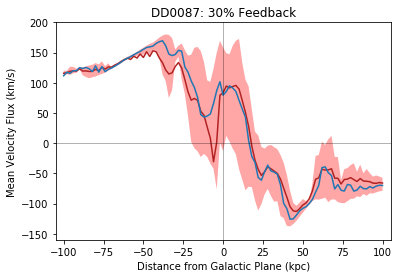

In [13]:
# Save the results from out dictionary as individual variables
nhl = results['height']
highperlist= results['highperlist']
lowperlist = results['lowperlist']
mean_flux_profile = results['mean_flux_profile']
median_flux_profile = results['median_flux_profile']

fig,axs=plt.subplots()

# Plots the 25th and 75th percentiles
axs.fill_between(nhl,highperlist,lowperlist,facecolor='r',alpha=.35)
# Plots mean velocity profile
axs.plot(nhl,mean_flux_profile,color='firebrick')
# Plots median velocity profile
axs.plot(nhl,median_flux_profile)

# Plots lines to make clear the difference between inflows and outflows
#     (positive or negative velocity), as well as above and below the
#     disk (positive (above) or negative (below) distance)
axs.plot([0,0],[-1000,1000],color='black',linewidth=.5,alpha=.6)
axs.plot([-1000,1000],[0,0],color='black',linewidth=.5,alpha=.6)
axs.set_xlim(-105,105)
axs.set_ylim(-160,200)

axs.set_xlabel('Distance from Galactic Plane (kpc)')
axs.set_ylabel('Mean Velocity Flux (km/s)')
axs.set_title(file_name[-6:]+': 30% Feedback')
plt.show()

# Weighted Velocity by Mass

In addition to the volume-weighted profile, there is also the option to calculate the mass-weighted velocity flux profile. This can be specified by setting the 'weight' argument to True. This adds an element to the output result that can be called by the keyword 'weighted_profile'.

In [16]:
# Define a data cylinder in which we will perform calculations
cyl = ds.disk(center,L,(12.,'kpc'),(200.,'kpc'))

# Create a dictionary containing velocity flux calculations
results1 = calculate_vflux_profile(cyl,-100,100,2,weight = True)

The mass-weighted velocity flux is plotted below in blue, alongside the mean velocity flux profiles.

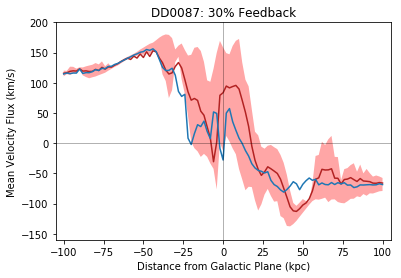

In [17]:
# Save the results from out dictionary as individual variables
nhl = results1['height']
highperlist= results1['highperlist']
lowperlist = results1['lowperlist']
mean_flux_profile = results1['mean_flux_profile']
weighted_profile = results1['weighted_profile']

fig,axs=plt.subplots()

# Plots the 25th and 75th percentiles
axs.fill_between(nhl,highperlist,lowperlist,facecolor='r',alpha=.35)
# Plots mean velocity profile
axs.plot(nhl,mean_flux_profile,color='firebrick')
# Plots mass weighted profile
axs.plot(nhl,weighted_profile)

# Plots lines to make clear the difference between inflows and outflows
#     (positive or negative velocity), as well as above and below the
#     disk (positive (above) or negative (below) distance)
axs.plot([0,0],[-1000,1000],color='black',linewidth=.5,alpha=.6)
axs.plot([-1000,1000],[0,0],color='black',linewidth=.5,alpha=.6)
axs.set_xlim(-105,105)
axs.set_ylim(-160,200)

axs.set_xlabel('Distance from Galactic Plane (kpc)')
axs.set_ylabel('Mean Velocity Flux (km/s)')
axs.set_title(file_name[-6:]+': 30% Feedback')
plt.show()

# Differentiating Between Outflows and Inflows

We are also able to differentiate between inflows and outflows by using the 'flow' argument, which has they keywords 'in', 'out', and 'all' (which is the default). It separates the inflows from the outflows by looking at the sign of the material's velocity flux at each point.

As before, it is important to remember whether you are looking above or below the disk. These keywords only apply to material above the disk, but if it is below the disk, the keywords must be reversed. For example, if you wanted to look for outflows below the disk, you would have to set the 'flow' argument to 'in', instead of out.

Also, the 25th and 75th percentiles are not calculated when differentiating between outflows and inflows.

In [ ]:
# Define a data cylinder in which we will perform calculations
cyl = ds.disk(center,L,(12.,'kpc'),(200.,'kpc'))

# Creates a dictionary containing the volume- and mass-weighted
#     velocity flux profiles for outflowing material
results2 = calculate_vflux_profile(cyl,0,100,2,weight=True,flow='out')

The volume- and mass-weighted profiles are plotted below.

In [ ]:
fig,axs=plt.subplots()

# Save the results from out dictionary as individual variables
nhl = results['height']
mean_flux_profile = results['mean_flux_profile']
wflux_profile = results['weighted_profile']

# Plots mean velocity profile
axs.plot(nhl,mean_flux_profile,color='firebrick')
# Plots mass weighted profile
axs.plot(nhl,wflux_profile)

# Plots lines to make clear the difference between inflows and outflows
#     (positive or negative velocity), as well as above and below the
#     disk (positive (above) or negative (below) distance)
axs.plot([0,0],[-1000,1000],color='black',linewidth=.5,alpha=.6)
axs.plot([-1000,1000],[0,0],color='black',linewidth=.5,alpha=.6)
axs.set_xlim(0,105)
axs.set_ylim(0,300)

axs.set_xlabel('Distance from Galactic Plane (kpc)')
axs.set_ylabel('Mean Velocity Flux (km/s)')
axs.set_title(file_name[-6:]+': 30% Feedback')
plt.show()